In [1]:
# CHECK ENVIRONMENT: 

import sys
print(sys.version)
print(sys.executable)

3.7.5 (default, Oct 31 2019, 15:18:51) [MSC v.1916 64 bit (AMD64)]
C:\Users\Dennis\anaconda3\envs\rc_env_np16p6\python.exe


In [2]:
import rescomp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [3]:
# help(rescomp)
# help(rescomp.esn)

In [4]:
esn_h1 = rescomp.esn.ESNHybrid()
esn_h2 = rescomp.esn.ESNHybrid()

In [5]:
simulation_time_steps = 8000
dt = 2e-2

starting_point = np.array([-14.03020521, -20.88693127, 25.53545])
sim_data = rescomp.simulate_trajectory(
    sys_flag='lorenz', dt=dt, time_steps=simulation_time_steps,
    starting_point=starting_point)

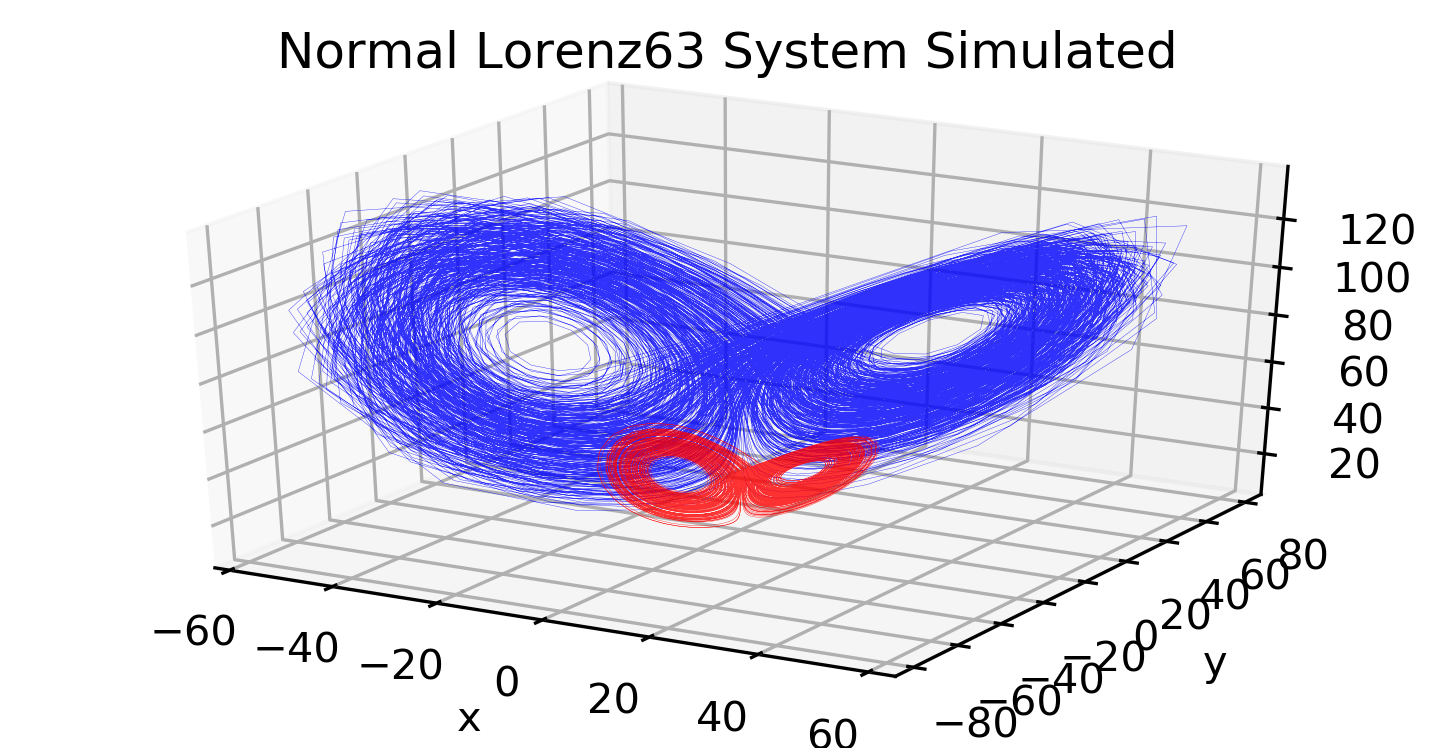

[[-14.03020521 -20.88693127  25.53545   ]
 [-21.57829572 -39.5626604   31.58361425]
 [-35.37912695 -62.12862757  54.16318337]
 [-49.88703475 -66.4622379  100.25413846]
 [-48.78081206 -28.69471816 131.93459383]] [[-14.03020521 -20.88693127  25.53545   ]
 [-15.25797688 -20.51030618  30.15606334]
 [-16.06372202 -18.7186594   34.62178262]
 [-16.27027628 -15.60166621  38.27016227]
 [-15.7840892  -11.61783523  40.55701638]]
(8000, 3) (8000, 3)


In [6]:
#Create artificially "wrong" model
eps1 = 2
eps2 = 2
eps3 = 2
model = lambda x: rescomp.simulations._normal_lorenz(x, sigma=10*(1+eps1), rho=28*(1+eps2), beta=8/3*(1+eps3))

# model_pred = lambda x: x + model(x)*dt

model_pred = lambda x: rescomp.simulations._runge_kutta(model, dt, x)

# test it:
x = np.zeros((simulation_time_steps, 3))

x[0] = starting_point
for i in range(1, simulation_time_steps):
    x_i = x[i-1]
    x[i] = model_pred(x_i)
    
fig = plt.figure(figsize=(6, 3), dpi=300)
ax = fig.add_subplot(111, projection='3d')
ax.plot(x[:, 0], x[:, 1], x[:, 2],
        alpha=0.8, color='blue', linewidth = 0.1)
ax.plot(sim_data[:, 0], sim_data[:, 1], sim_data[:, 2],
        alpha=0.8, color='red', linewidth = 0.1)

# dif = sim_data - x
# ax.plot(dif[:, 0], dif[:, 1], dif[:, 2],
#         alpha=0.8, color='red', linewidth = 0.1)

ax.set_title("Normal Lorenz63 System Simulated")
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

print(x[:5], sim_data[:5])

print(x.shape, sim_data.shape)

In [7]:
np.random.seed(1)
n_dim = 500


# hybrid esn with model only in output
esn_h1.create_network(n_dim = n_dim)
add_model_to_input = False
esn_h1.set_model(model_pred, add_model_to_input = add_model_to_input)

np.random.seed(1)
# hybrid esn with model in in- and output
esn_h2.create_network(n_dim = n_dim)
add_model_to_input = True
gamma = 0.5
esn_h2.set_model(model_pred, add_model_to_input = add_model_to_input, gamma = gamma)

train_sync_steps = 400
train_steps = 4000
pred_steps = 1000  

In [8]:
# for e in [esn_h1, esn_h2]:
#     print("start")
#     print(e._network)
    
# # -> Same Network because np.random.seed works

In [9]:
np.random.seed(1)
y_pred_h1, y_test_h1 = esn_h1.train_and_predict(
    x_data=sim_data, train_sync_steps=train_sync_steps, train_steps=train_steps, 
    pred_steps=pred_steps)

np.random.seed(1)
y_pred_h2, y_test_h2 = esn_h2.train_and_predict(
    x_data=sim_data, train_sync_steps=train_sync_steps, train_steps=train_steps, 
    pred_steps=pred_steps)

print(y_test_h1 == y_test_h2)

r_gen shape:  (3999, 500)
u_train shape:  (3999, 3)
xshape and model(x) shape:  (400, 3) (400, 3)
xshape after:  (400, 6)
win  shape:  (500, 6)
xshape and model(x) shape:  (3999, 3) (3999, 3)
xshape after:  (3999, 6)
win  shape:  (500, 6)
r_gen shape:  (3999, 500)
u_train shape:  (3999, 3)
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]
 ...
 [ True  True  True]
 [ True  True  True]
 [ True  True  True]]


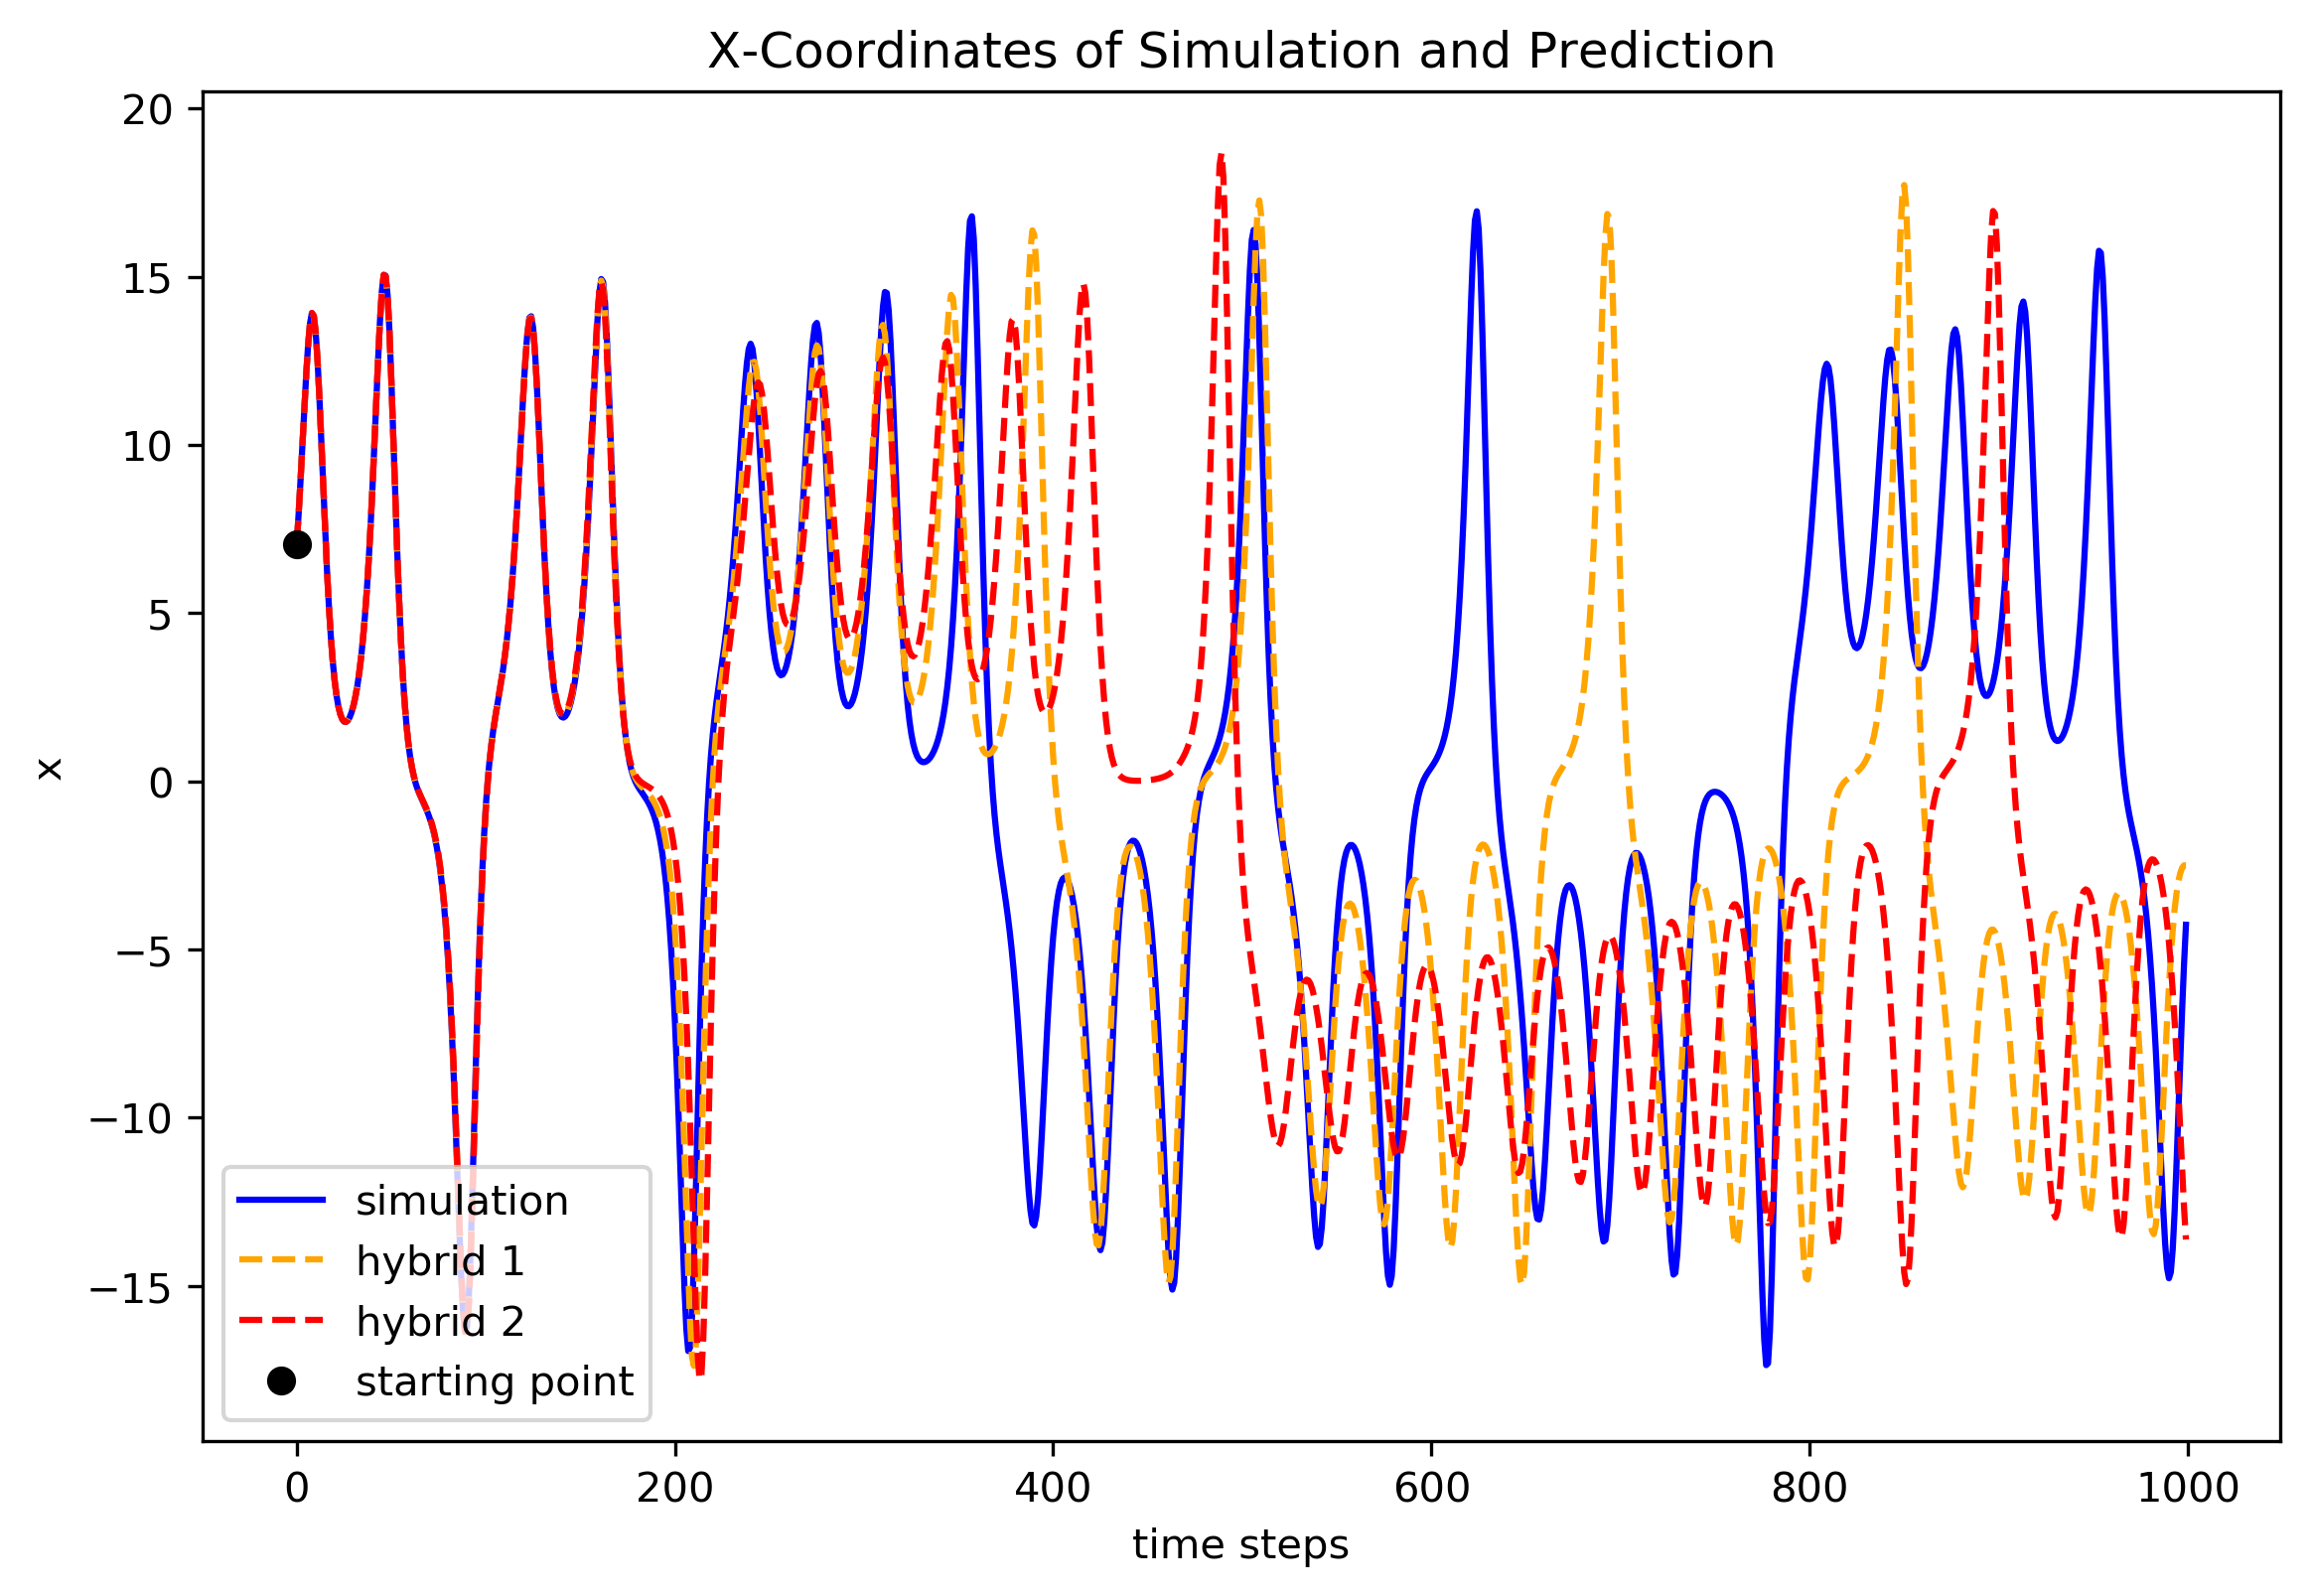

In [10]:
fig2 = plt.figure(figsize=(9, 6), dpi=300)
ax2 = fig2.add_subplot(1, 1, 1)
ax2.plot(y_test_h1[:, 0], color='blue', label='simulation')
ax2.plot(y_pred_h1[:, 0], color='orange', linestyle='--', label='hybrid 1')
ax2.plot(y_pred_h2[:, 0], color='red', linestyle='--', label='hybrid 2')


start = y_test_h1[0]
ax2.plot(start[0], color='black', linestyle='', marker='o', 
         label='starting point')

ax2.set_title("X-Coordinates of Simulation and Prediction")
ax2.set_xlabel('time steps')
ax2.set_ylabel('x')
plt.legend()
plt.show()

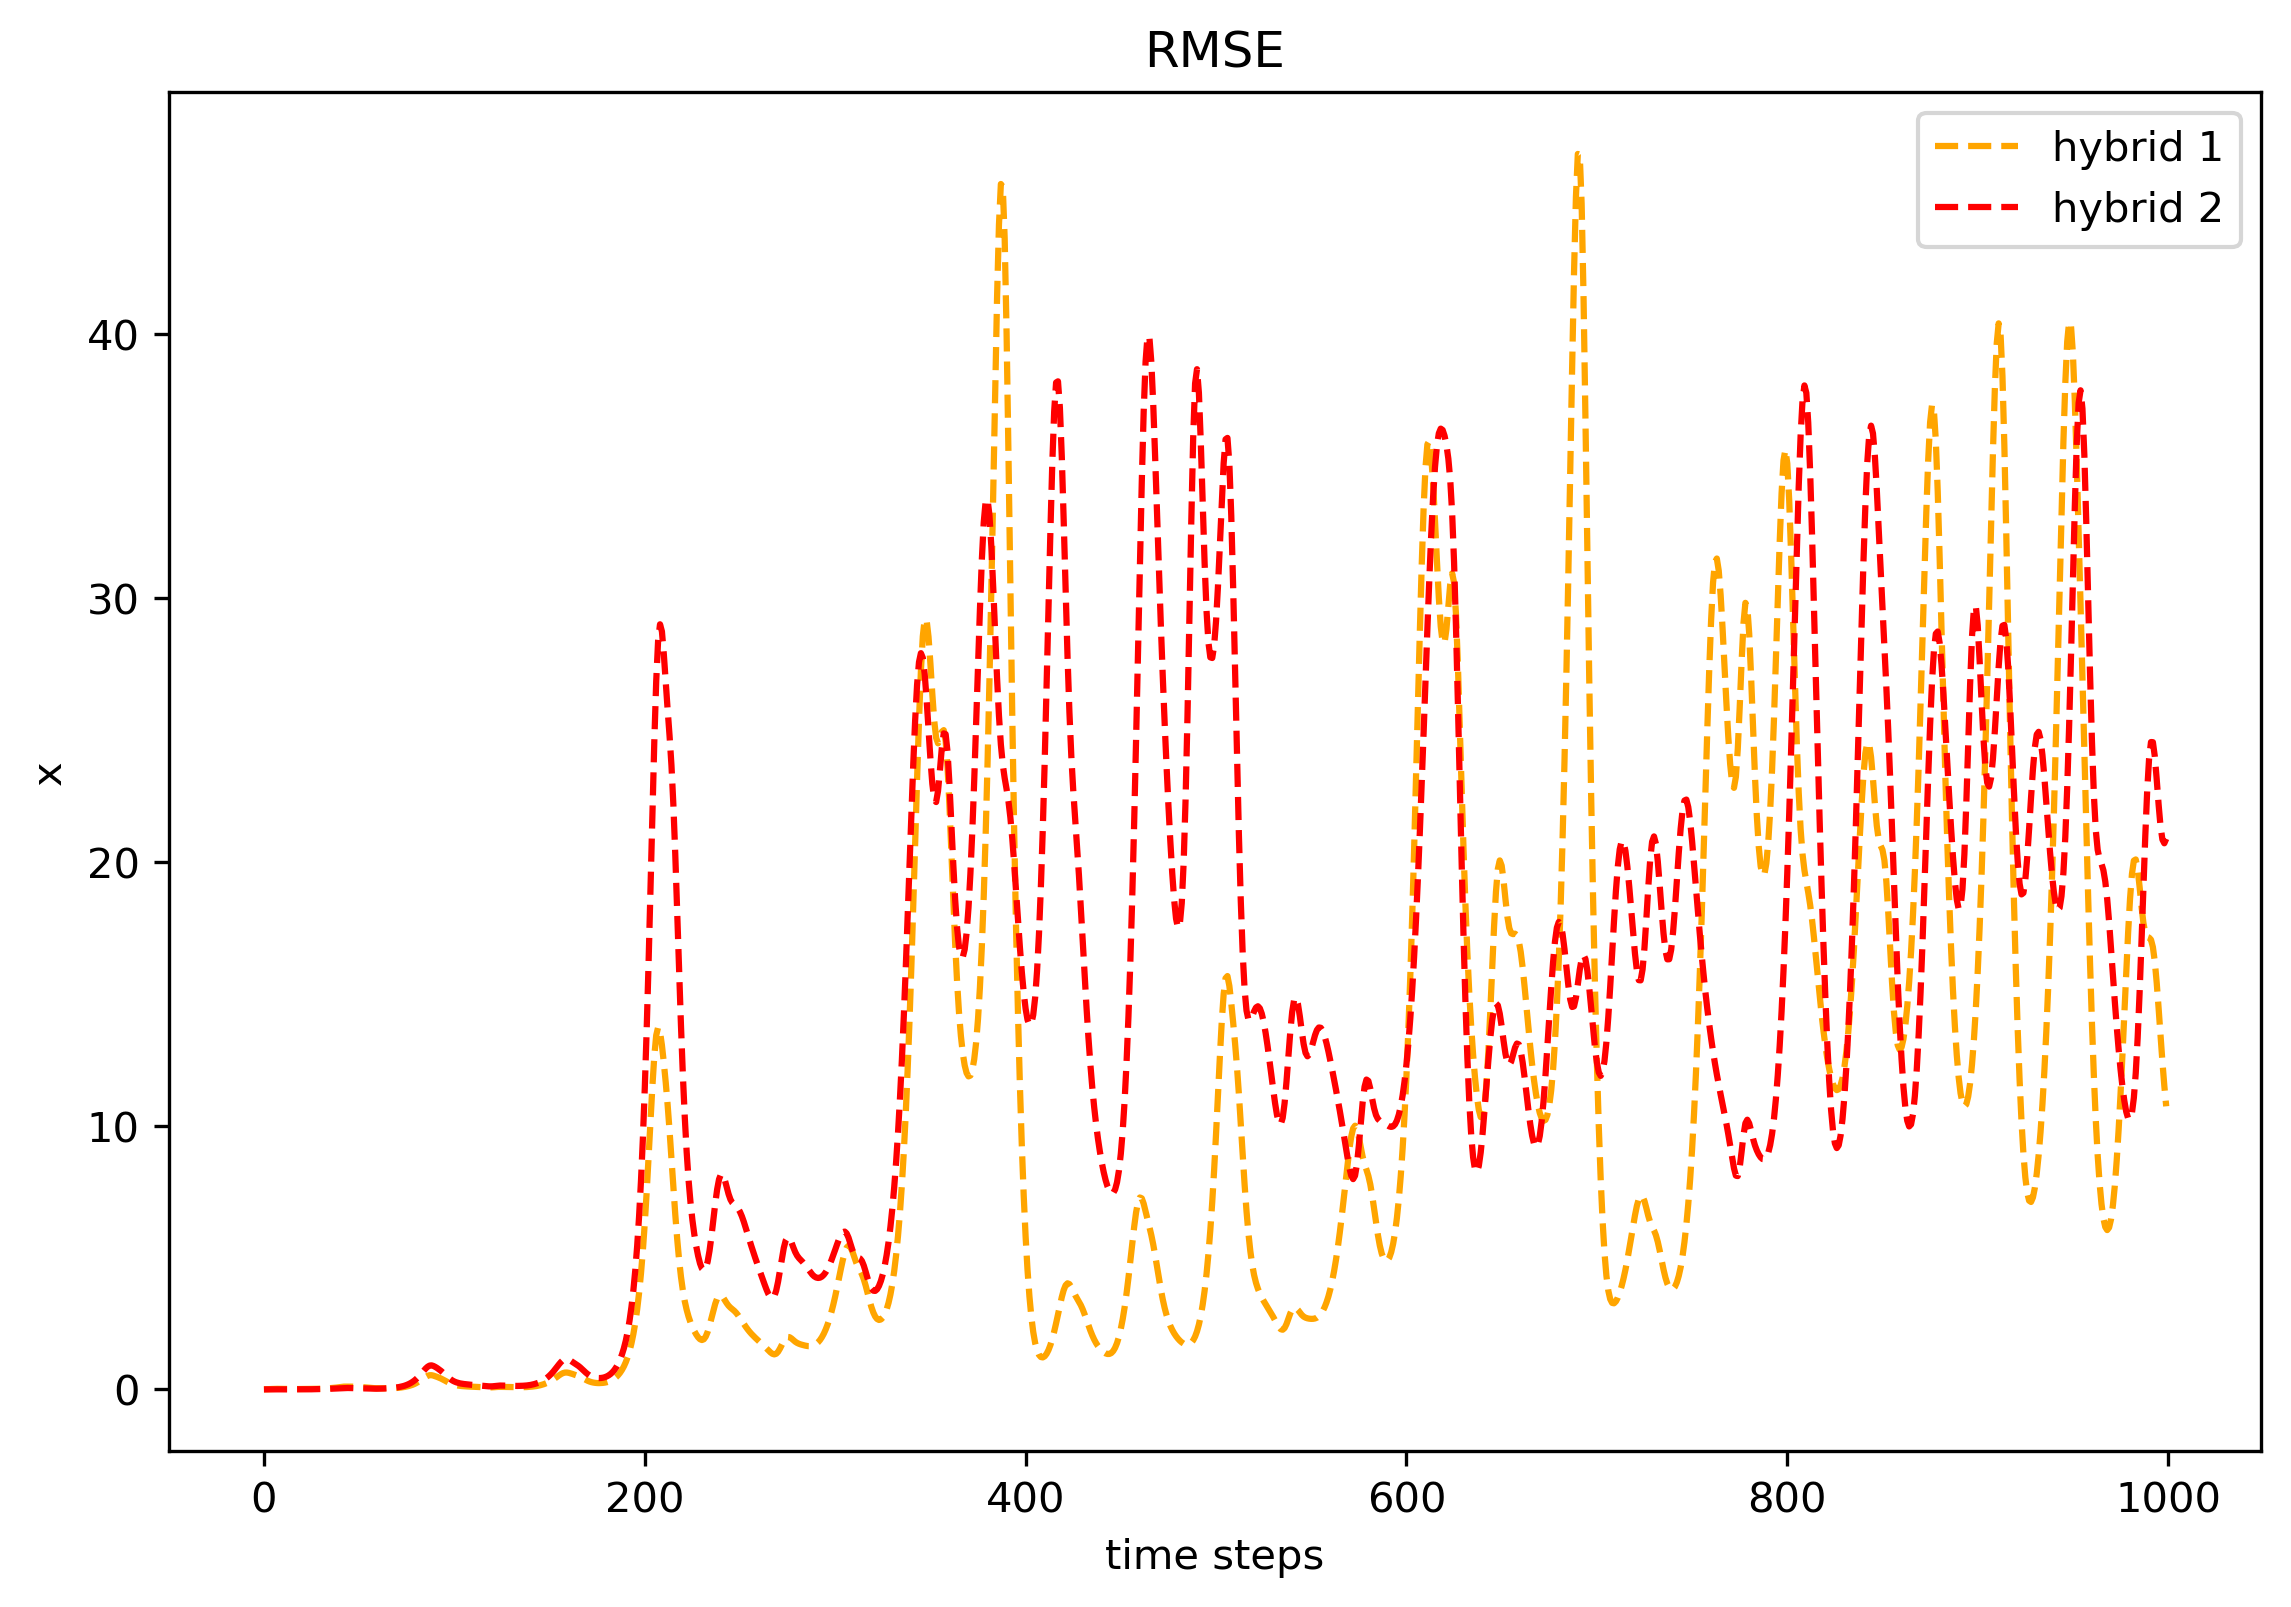

RMSE_h1:  10.542925299926226
RMSE_h2:  14.080815614842052


In [11]:
rmse_h1 = rescomp.measures.rmse_over_time(y_pred_h1, y_test_h1)
rmse_h2 = rescomp.measures.rmse_over_time(y_pred_h2, y_test_h2)

fig2 = plt.figure(figsize=(9, 6), dpi=300)
ax2 = fig2.add_subplot(1, 1, 1)
ax2.plot(rmse_h1, color='orange', linestyle='--', label='hybrid 1')
ax2.plot(rmse_h2, color='red', linestyle='--', label='hybrid 2')


ax2.set_title("RMSE")
ax2.set_xlabel('time steps')
ax2.set_ylabel('x')
plt.legend()
plt.show()

print("RMSE_h1: ", np.average(rmse_h1))
print("RMSE_h2: ", np.average(rmse_h2))

In [12]:
print(esn_h1._w_out.shape)
print(esn_h2._w_out.shape)

print("Model output weights: ", np.average(np.abs(esn_h1._w_out[:, -3:])))
print("reservoir output weights: ", np.average(np.abs(esn_h1._w_out[:, :-3])))

print("Model output weights: ", np.average(np.abs(esn_h1._w_out[:, -3:])))
print("reservoir output weights: ", np.average(np.abs(esn_h2._w_out[:, :-3])))

(3, 503)
(3, 503)
Model output weights:  0.35121407284401324
reservoir output weights:  0.8065194348467591
Model output weights:  0.35121407284401324
reservoir output weights:  0.6336284729823778


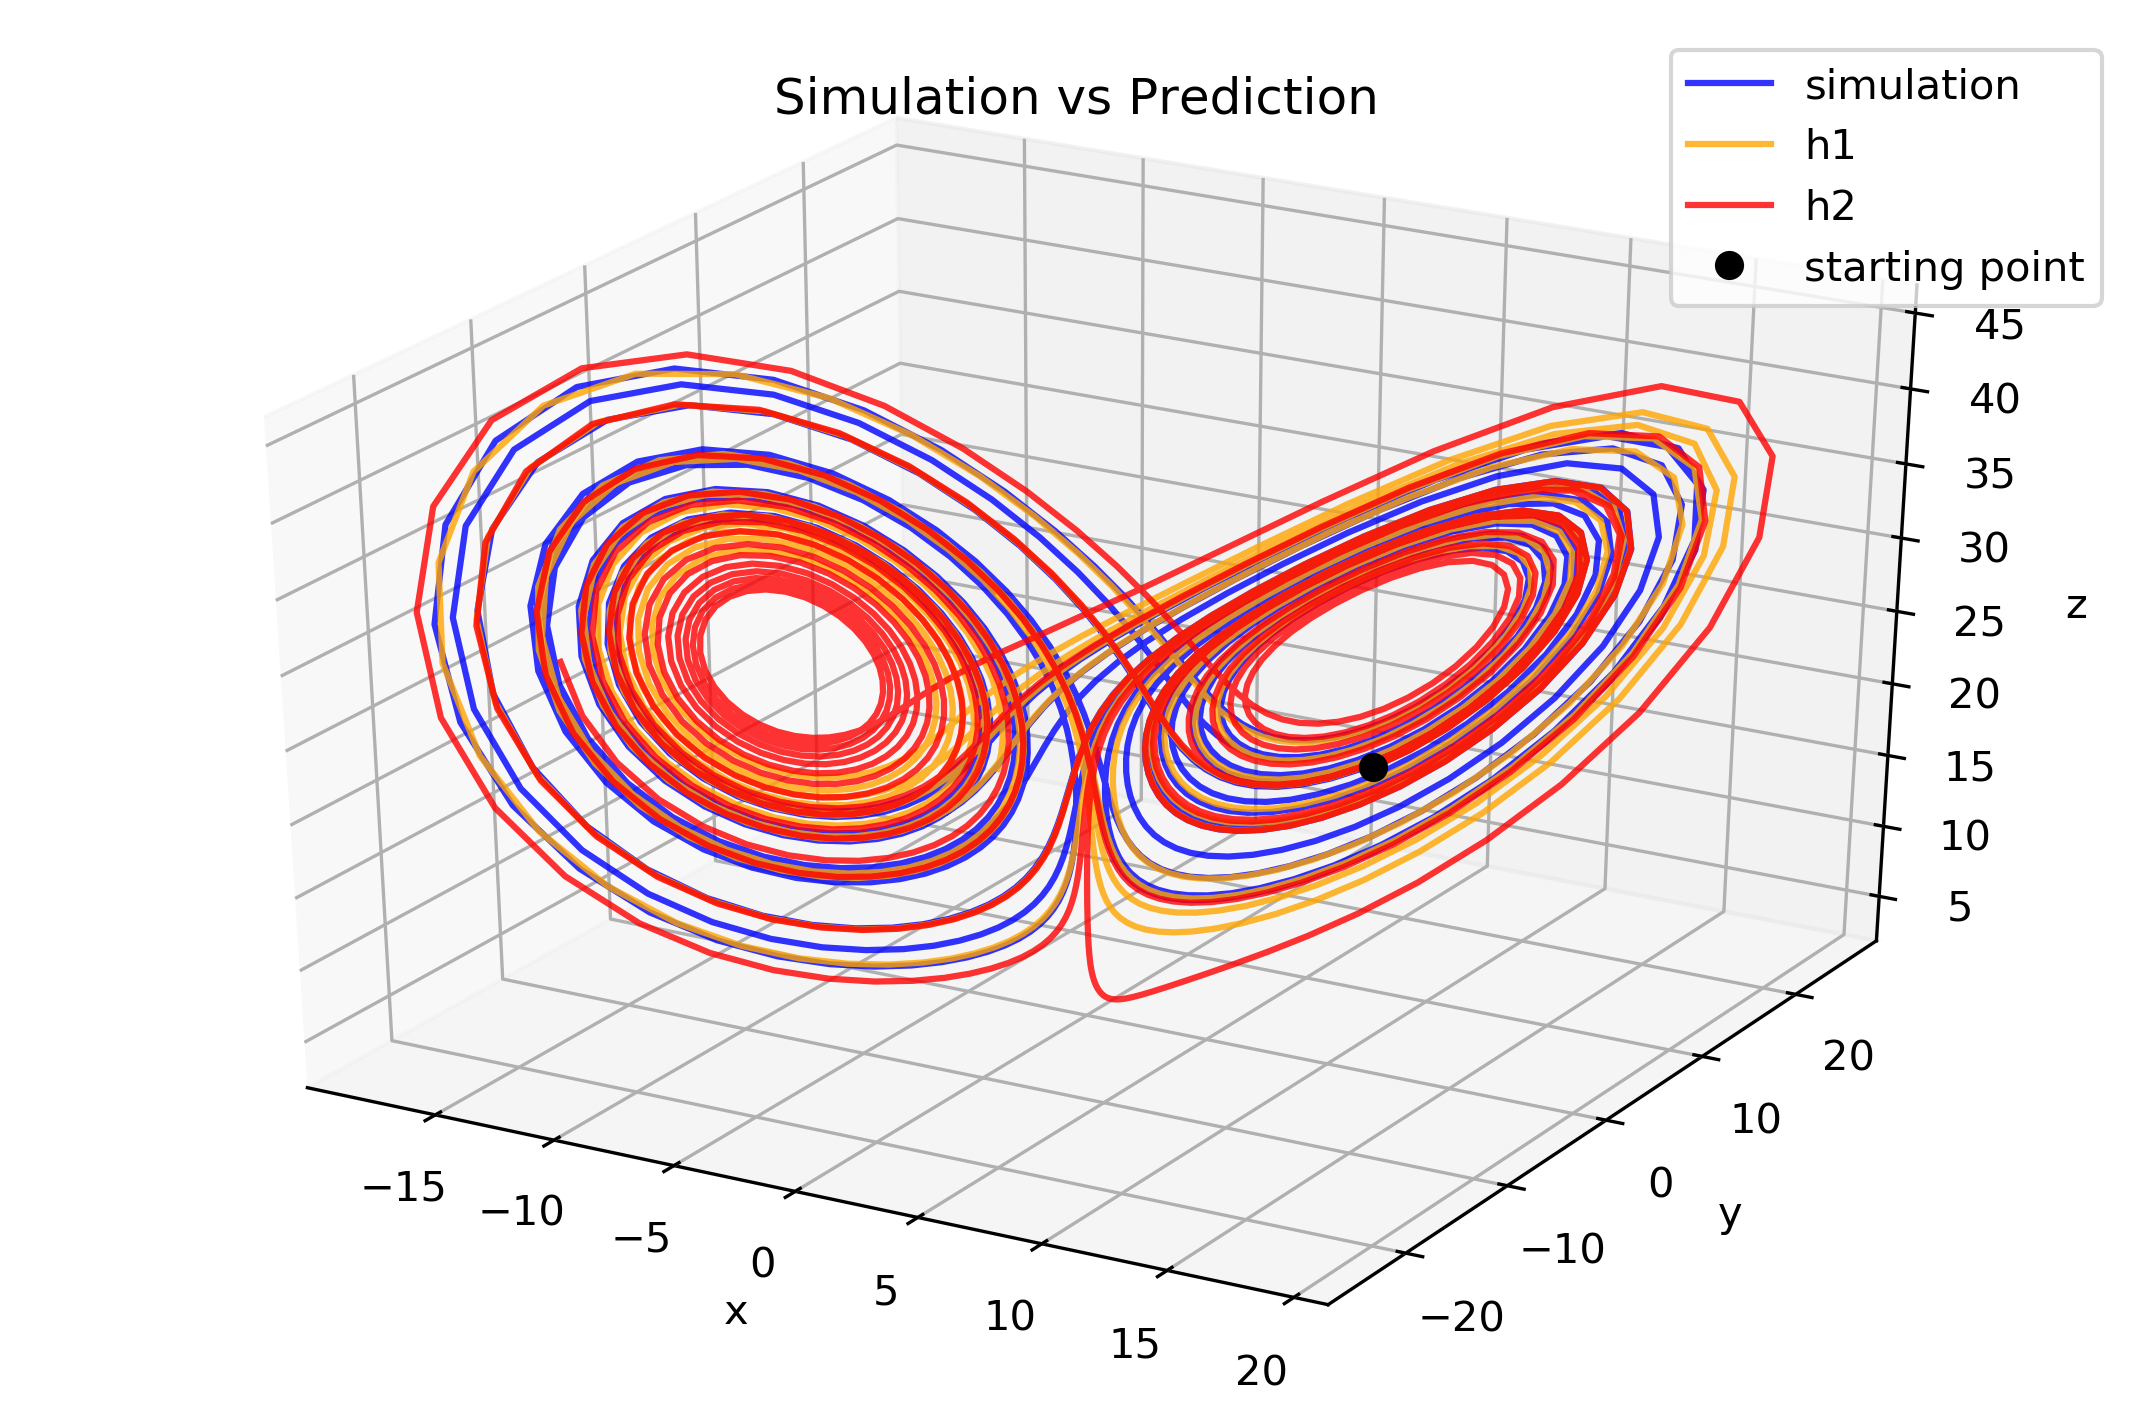

In [13]:
fig1 = plt.figure(figsize=(9, 6), dpi=300)
ax1 = fig1.add_subplot(111, projection='3d')

ax1.plot(y_test_h1[:, 0], y_test_h1[:, 1], y_test_h1[:, 2],
        alpha=0.8, color='blue', label='simulation')
ax1.plot(y_pred_h1[:, 0], y_pred_h1[:, 1], y_pred_h1[:, 2],
        alpha=0.8, color='orange', label='h1')
ax1.plot(y_pred_h2[:, 0], y_pred_h2[:, 1], y_pred_h2[:, 2],
        alpha=0.8, color='red', label='h2')

start = y_test_h1[0]
ax1.plot([start[0]], [start[1]], [start[2]], 
         color='black', linestyle='', marker='o', label='starting point')

ax1.set_title("Simulation vs Prediction")
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
plt.legend()
plt.show()

In [14]:
print(esn_h1._w_in)
print(esn_h2._w_in)

[[ 0.40703398  0.          0.        ]
 [ 0.          0.         -0.18739139]
 [ 0.          0.         -0.93085756]
 ...
 [ 0.          0.          0.16207131]
 [-0.2175658   0.          0.        ]
 [ 0.78886484  0.          0.        ]]
[[ 0.40703398  0.          0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         -0.7113692   0.        ]
 [ 0.          0.          0.          0.          0.4176346   0.        ]
 ...
 [ 0.          0.          0.         -0.2175658   0.          0.        ]
 [ 0.          0.          0.          0.78886484  0.          0.        ]
 [ 0.         -0.56379963  0.          0.          0.          0.        ]]
